In [101]:
# import all required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA, TruncatedSVD
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder

In [2]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 3.7 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
# ignore all the warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# read the dataset 
df = pd.read_csv("/Users/hkannan/Desktop/COMP90089_MLAH/Dataset_final/High_LP_Scan_AP_ICD/High_LP_Scan_AP_Comorbidities_Dataset.csv")

In [6]:
df

,subject_id,hadm_id,charttime,lipase_level,admittime,dischtime,gender,age,race,in_hospital_death,length_of_stay,icd_code_AP,icd_code,seq_num,icd_version,long_title
0,10017531,22580355,2159-09-22 20:56:00,1164.0,2159-09-22 19:30:00,2159-10-24 13:40:00,M,63,WHITE,False,31.756944,5770,5770,1,9,Acute pancreatitis
1,10017531,22580355,2159-09-22 20:56:00,1164.0,2159-09-22 19:30:00,2159-10-24 13:40:00,M,63,WHITE,False,31.756944,5770,51881,2,9,Acute respiratory failure
2,10017531,22580355,2159-09-22 20:56:00,1164.0,2159-09-22 19:30:00,2159-10-24 13:40:00,M,63,WHITE,False,31.756944,5770,5849,3,9,"Acute kidney failure, unspecified"
3,10017531,22580355,2159-09-22 20:56:00,1164.0,2159-09-22 19:30:00,2159-10-24 13:40:00,M,63,WHITE,False,31.756944,5770,42822,4,9,Chronic systolic heart failure
4,10017531,22580355,2159-09-22 20:56:00,1164.0,2159-09-22 19:30:00,2159-10-24 13:40:00,M,63,WHITE,False,31.756944,5770,7907,5,9,Bacteremia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,19720119,28060710,2180-12-07 14:56:00,757.0,2180-12-01 00:04:00,2180-12-20 13:30:00,F,45,WHITE,False,19.559722,K8590,F329,13,10,"Major depressive disorder, single episode, uns..."
3810,19720119,28060710,2180-12-07 14:56:00,757.0,2180-12-01 00:04:00,2180-12-20 13:30:00,F,45,WHITE,False,19.559722,K8590,Z23,14,10,Encounter for immunization
3811,19720119,28060710,2180-12-07 14:56:00,757.0,2180-12-01 00:04:00,2180-12-20 13:30:00,F,45,WHITE,False,19.559722,K8590,G932,15,10,Benign intracranial hypertension
3812,19720119,28060710,2180-12-07 14:56:00,757.0,2180-12-01 00:04:00,2180-12-20 13:30:00,F,45,WHITE,False,19.559722,K8590,Z781,16,10,Physical restraint status


In [7]:
# concatenate all unique diseases as features
disease_dummies = pd.get_dummies(df['long_title'])
data = pd.concat([df, disease_dummies], axis=1).drop('long_title', axis=1)

In [149]:
# aggregate all the rows into unique patients based on subject_id
aggregated_data = data.groupby('subject_id').agg({
    'lipase_level': 'first', 
    'age': 'first',
    'gender': 'first',
    'race': 'first',
    'in_hospital_death': 'max',  # If death recorded in any row, we consider the patient deceased
    'length_of_stay': 'first', 
    **{col: 'max' for col in disease_dummies.columns}  # max for binary disease presence across multiple rows
}).reset_index()

In [150]:
aggregated_data

,subject_id,lipase_level,age,gender,race,in_hospital_death,length_of_stay,Abdominal aneurysm without mention of rupture,Abnormal coagulation profile,Abnormal results of thyroid function studies,...,Venous thrombosis nec,Ventilator associated pneumonia,Ventricular fibrillation,Ventricular tachycardia,"Viral hepatitis B without mention of hepatic coma, acute or unspecified, without mention of hepatitis delta","Viral infection, unspecified","Viremia, unspecified",Vitamin B12 deficiency anemia due to intrinsic factor deficiency,"Vitamin D deficiency, unspecified",Wernicke's encephalopathy
0,10017531,1164.0,63,M,WHITE,False,31.756944,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,10036086,677.0,57,M,WHITE,False,23.371528,False,True,False,...,False,False,False,False,True,False,False,False,False,False
2,10143030,563.0,63,M,WHITE,True,94.836806,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,10246670,850.0,44,M,BLACK/AFRICAN AMERICAN,False,15.643056,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,10309969,747.0,68,F,WHITE,False,26.538889,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,19363916,506.0,67,M,WHITE,False,43.654167,False,False,False,...,False,False,False,False,False,False,False,False,False,False
152,19619252,1722.0,54,M,BLACK/AFRICAN AMERICAN,False,22.046528,False,False,False,...,False,False,False,False,False,False,False,False,False,False
153,19655310,669.0,41,F,WHITE,False,59.418750,False,False,False,...,False,False,False,False,False,False,False,False,False,False
154,19676211,980.0,79,F,WHITE,True,28.930556,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [151]:
# grouping all variants of AP into single column
columns_to_drop = [col for col in aggregated_data.columns if 'acute pancreatitis' in col.lower()]
columns_to_drop,len(columns_to_drop)

(['Acute pancreatitis',
  'Acute pancreatitis with infected necrosis, unspecified',
  'Acute pancreatitis with uninfected necrosis, unspecified',
  'Acute pancreatitis without necrosis or infection, unspecified',
  'Acute pancreatitis, unspecified',
  'Alcohol induced acute pancreatitis',
  'Alcohol induced acute pancreatitis with uninfected necrosis',
  'Alcohol induced acute pancreatitis without necrosis or infection',
  'Biliary acute pancreatitis with infected necrosis',
  'Biliary acute pancreatitis with uninfected necrosis',
  'Biliary acute pancreatitis without necrosis or infection',
  'Idiopathic acute pancreatitis without necrosis or infection',
  'Other acute pancreatitis',
  'Other acute pancreatitis with infected necrosis',
  'Other acute pancreatitis without necrosis or infection'],
 15)

In [157]:
aggregated_data['Acute pancreatitis']

0      True
1      True
2      True
3      True
4      True
       ... 
151    True
152    True
153    True
154    True
155    True
Name: Acute pancreatitis, Length: 156, dtype: bool

In [152]:
aggregated_data.drop(columns = columns_to_drop, inplace = True)
aggregated_data['Acute pancreatitis'] = True
aggregated_data

,subject_id,lipase_level,age,gender,race,in_hospital_death,length_of_stay,Abdominal aneurysm without mention of rupture,Abnormal coagulation profile,Abnormal results of thyroid function studies,...,Ventilator associated pneumonia,Ventricular fibrillation,Ventricular tachycardia,"Viral hepatitis B without mention of hepatic coma, acute or unspecified, without mention of hepatitis delta","Viral infection, unspecified","Viremia, unspecified",Vitamin B12 deficiency anemia due to intrinsic factor deficiency,"Vitamin D deficiency, unspecified",Wernicke's encephalopathy,Acute pancreatitis
0,10017531,1164.0,63,M,WHITE,False,31.756944,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,10036086,677.0,57,M,WHITE,False,23.371528,False,True,False,...,False,False,False,True,False,False,False,False,False,True
2,10143030,563.0,63,M,WHITE,True,94.836806,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,10246670,850.0,44,M,BLACK/AFRICAN AMERICAN,False,15.643056,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,10309969,747.0,68,F,WHITE,False,26.538889,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,19363916,506.0,67,M,WHITE,False,43.654167,False,False,False,...,False,False,False,False,False,False,False,False,False,True
152,19619252,1722.0,54,M,BLACK/AFRICAN AMERICAN,False,22.046528,False,False,False,...,False,False,False,False,False,False,False,False,False,True
153,19655310,669.0,41,F,WHITE,False,59.418750,False,False,False,...,False,False,False,False,False,False,False,False,False,True
154,19676211,980.0,79,F,WHITE,True,28.930556,False,False,False,...,False,False,True,False,False,False,False,False,False,True


<H1>EDA</H1>

In [153]:
# check if null values are present in the dataset
aggregated_data.isna().sum()

subject_id                                                          0
lipase_level                                                        0
age                                                                 0
gender                                                              0
race                                                                0
                                                                   ..
Viremia, unspecified                                                0
Vitamin B12 deficiency anemia due to intrinsic factor deficiency    0
Vitamin D deficiency, unspecified                                   0
Wernicke's encephalopathy                                           0
Acute pancreatitis                                                  0
Length: 1248, dtype: int64

### Dataset Overview 

In [78]:
Total_patients = 180677
AP_count = [3849, 1366, 156]
AP_death = [141, 69, 31]

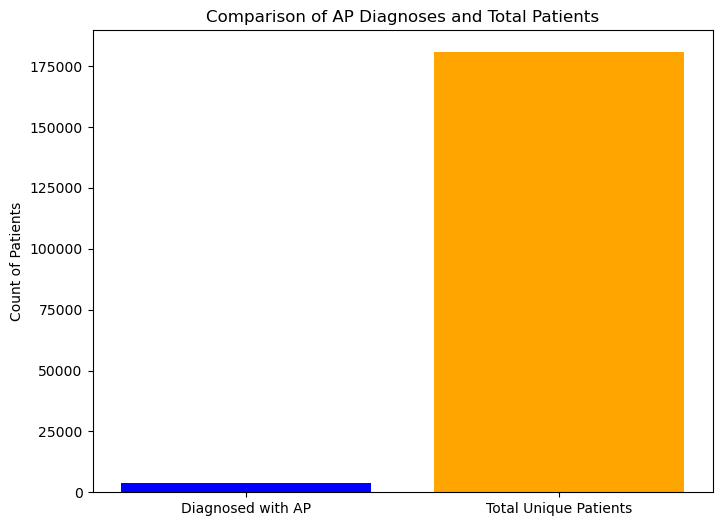

In [92]:
count_diagnosed_with_AP = AP_count[0]
total_unique_patients = Total_patients

# Labels and counts
labels = ['Diagnosed with AP', 'Total Unique Patients']
counts = [count_diagnosed_with_AP, total_unique_patients]

# Create bar chart
plt.figure(figsize=(8, 6))  # Set figure size
plt.bar(labels, counts, color = ['blue', 'orange'])  # Plot bars with different colors

# Adding titles and labels
plt.title('Comparison of AP Diagnoses and Total Patients')
plt.ylabel('Count of Patients')

# Show plot
plt.show()

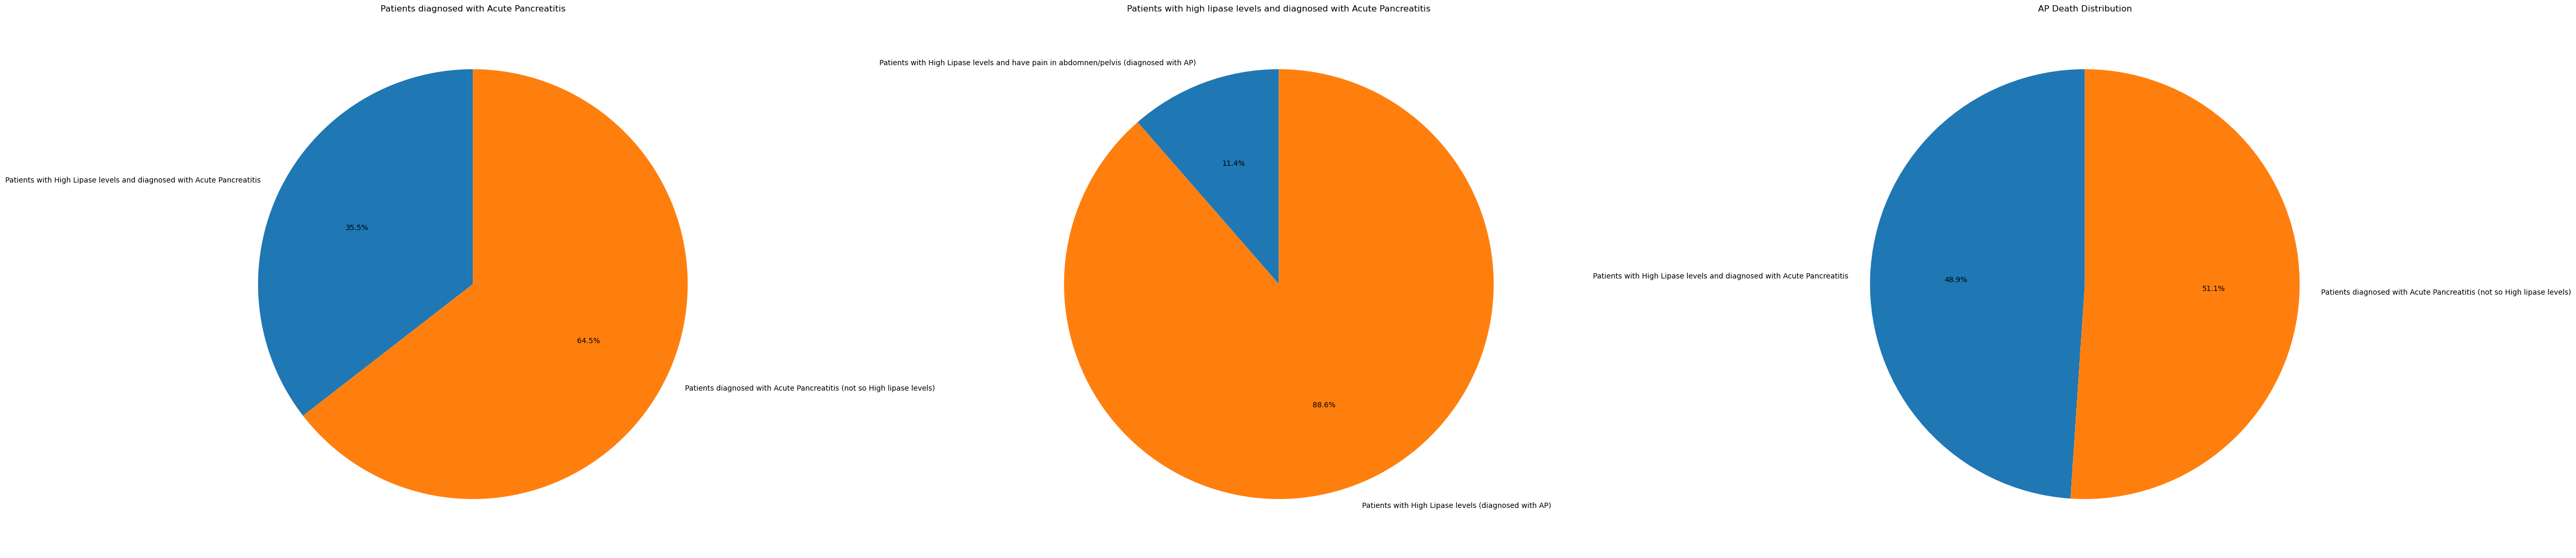

In [89]:
# Labels for the slices
labels_group1 = ['Patients with High Lipase levels and diagnosed with Acute Pancreatitis', 'Patients diagnosed with Acute Pancreatitis (not so High lipase levels)']
labels_group2 = ['Patients with High Lipase levels and have pain in abdomnen/pelvis (diagnosed with AP)', 'Patients with High Lipase levels (diagnosed with AP)']

# Create a figure with three subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize = (48, 12))  # 18x6 figure size

# Adjust the data to reflect nested groups
counts_group1_exclusive = [AP_count[1], AP_count[0] - AP_count[1]]
counts_group2_exclusive = [AP_count[2], AP_count[1] - AP_count[2]]
deaths_group1_exclusive = [AP_death[1], AP_death[0] - AP_death[1]]

# Plotting the pie charts
axs[0].pie(counts_group1_exclusive, labels = labels_group1, autopct = '%1.1f%%', startangle = 90)
axs[0].set_title('Patients diagnosed with Acute Pancreatitis')

axs[1].pie(counts_group2_exclusive, labels = labels_group2, autopct = '%1.1f%%', startangle = 90)
axs[1].set_title('Patients with high lipase levels and diagnosed with Acute Pancreatitis')

axs[2].pie(deaths_group1_exclusive, labels = labels_group1, autopct = '%1.1f%%', startangle = 90)
axs[2].set_title('AP Death Distribution')

# Show the plot
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

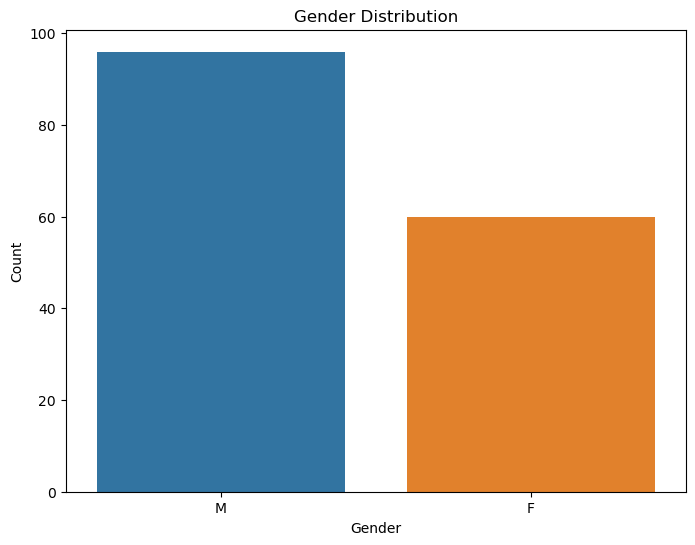

In [63]:
# visualize the distribution of data (features)
# Gender
plt.figure(figsize = (8, 6))
sns.countplot(x = 'gender', data = aggregated_data)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

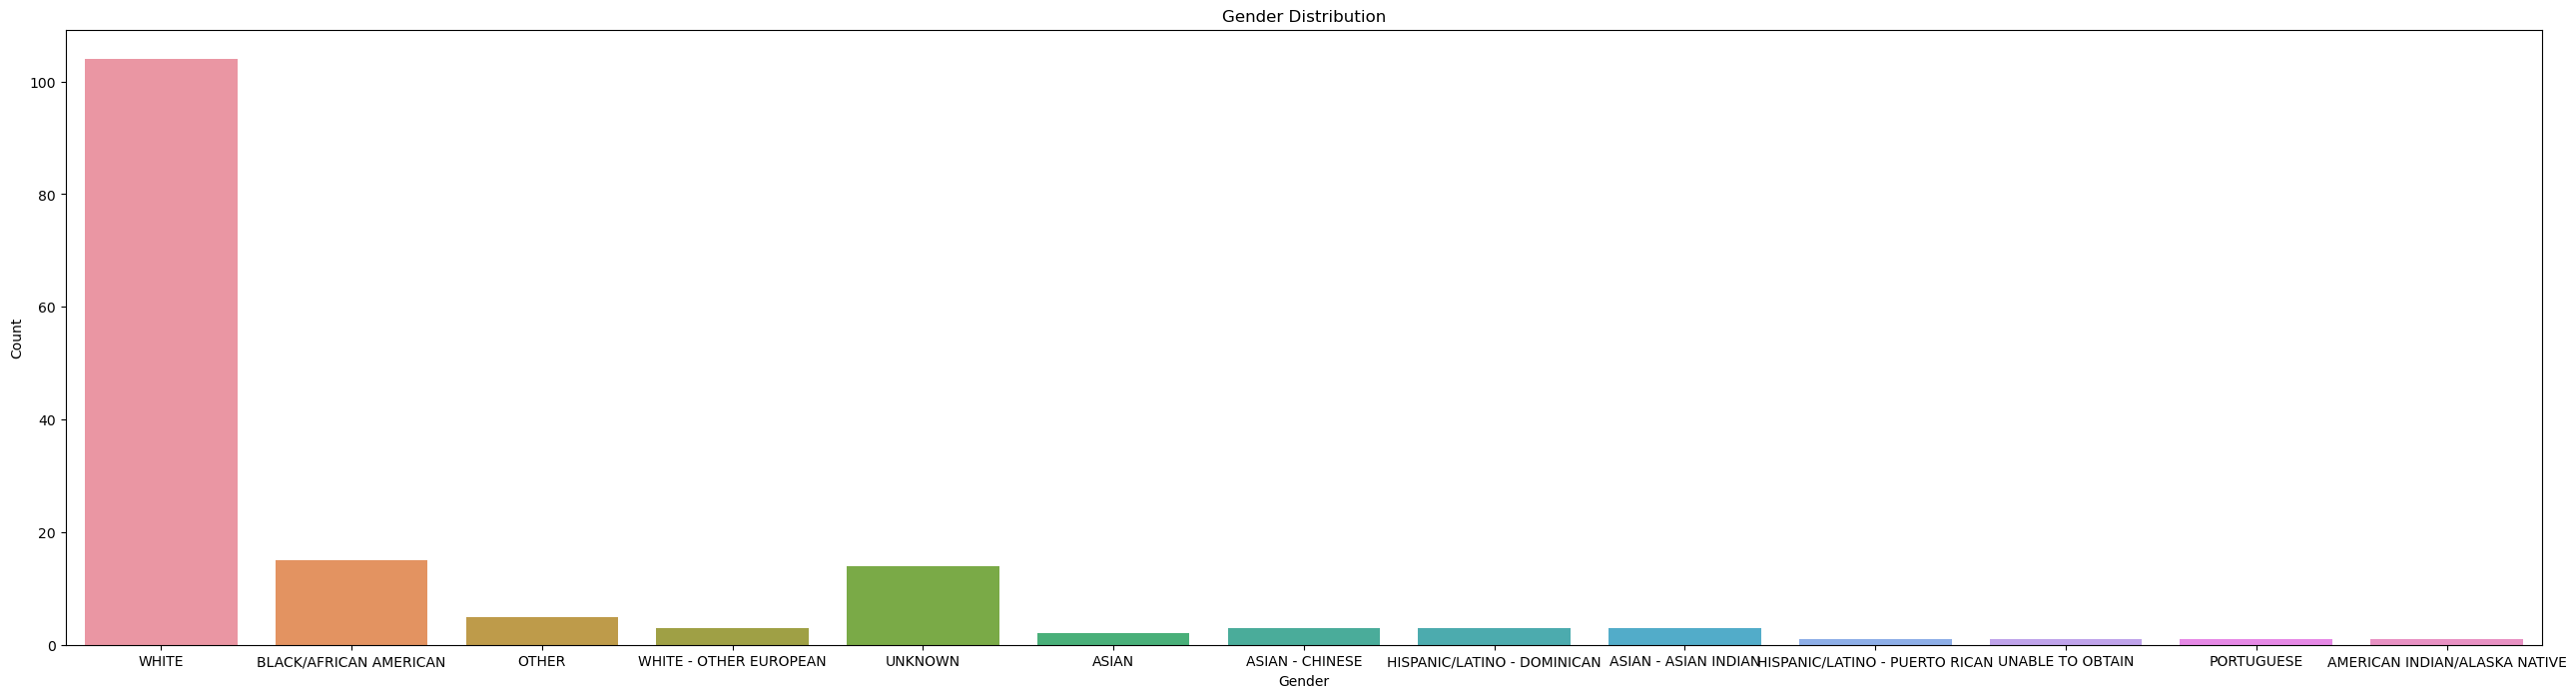

In [73]:
# Race
plt.figure(figsize = (32, 8))
sns.countplot(x = 'race', data = aggregated_data)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

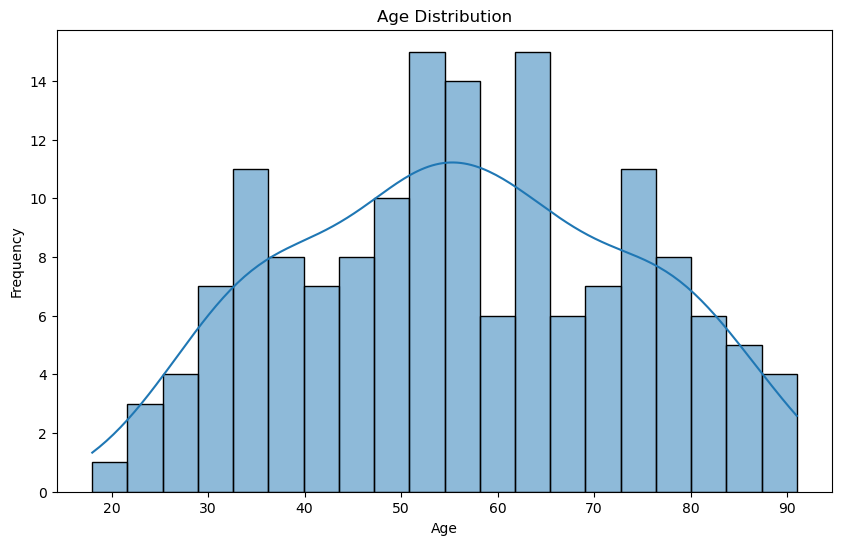

In [64]:
# Age
plt.figure(figsize = (10, 6))
sns.histplot(aggregated_data['age'], bins = 20, kde = True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

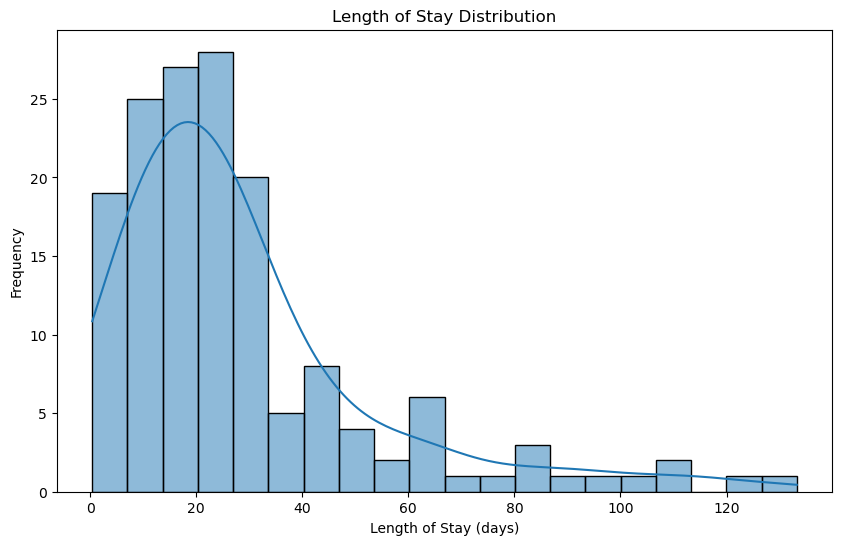

In [65]:
# Length of stay
plt.figure(figsize = (10, 6))
sns.histplot(aggregated_data['length_of_stay'], bins = 20, kde = True)
plt.title('Length of Stay Distribution')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

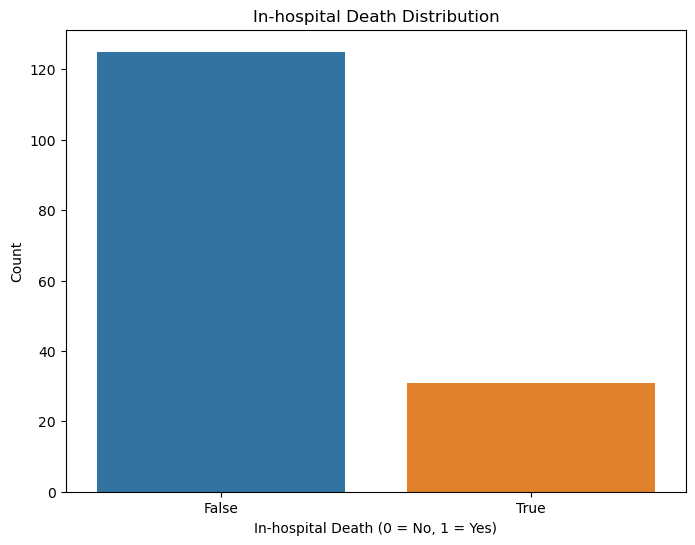

In [74]:
# In-hospital death
plt.figure(figsize = (8, 6))
sns.countplot(x = 'in_hospital_death', data = aggregated_data)
plt.title('In-hospital Death Distribution')
plt.xlabel('In-hospital Death (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

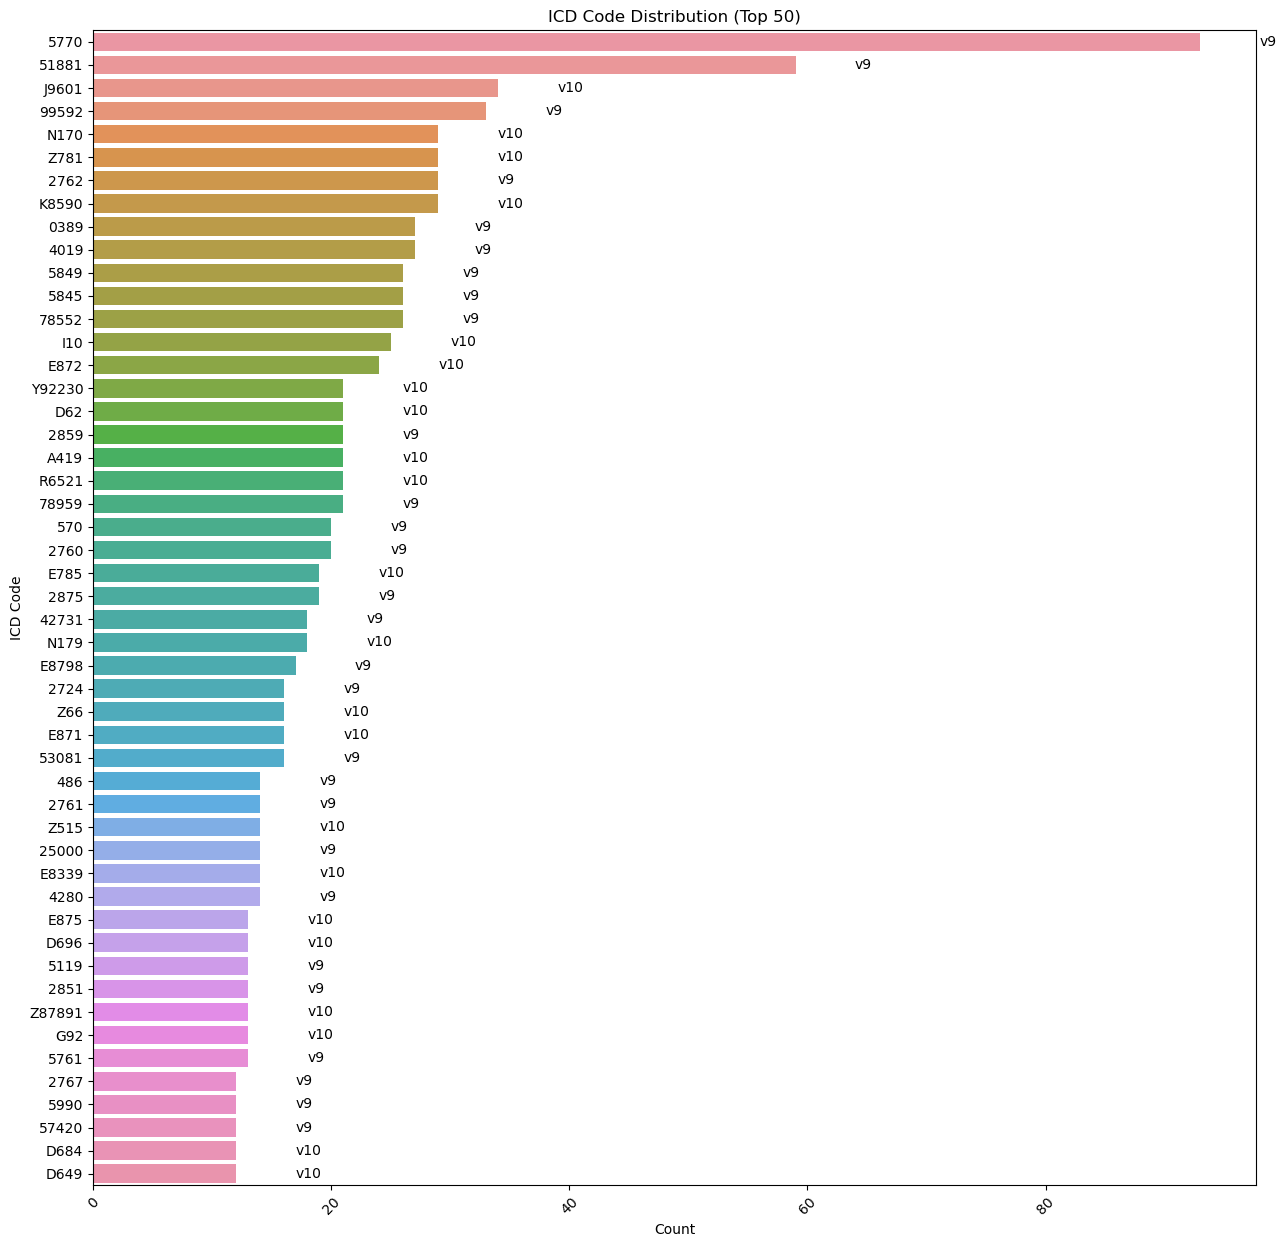

In [76]:
# ICD codes distribution
plt.figure(figsize = (15, 15))
ax = sns.countplot(y = 'icd_code',
                   data = df,
                   order = df['icd_code'].value_counts().index[:50])
plt.title('ICD Code Distribution (Top 50)')
plt.xlabel('Count')
plt.ylabel('ICD Code')
for index, patch in enumerate(ax.patches):
    icd_code = df['icd_code'].value_counts().index[:50][index]
    icd_version = df.loc[df['icd_code'] == icd_code, 'icd_version'].iloc[0]
    x = patch.get_width() + 5
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f'v{icd_version}', va='center')
plt.xticks(rotation=45)
plt.show()

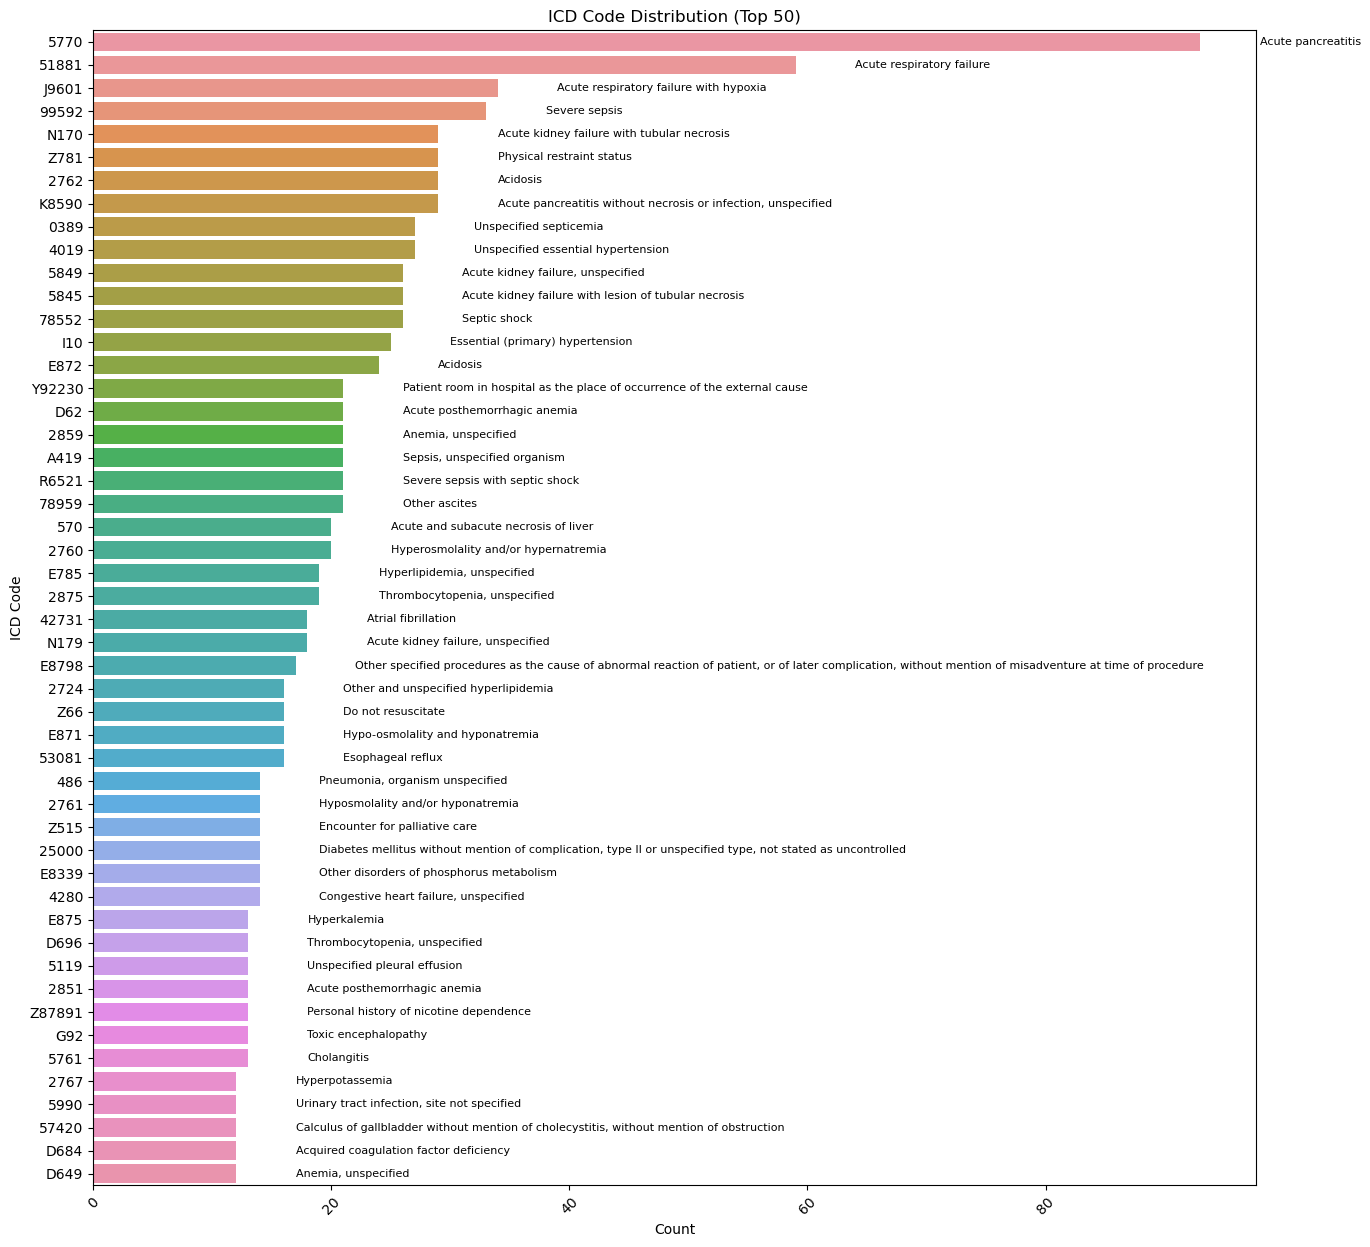

In [77]:
# ICD codes distribution
plt.figure(figsize = (15, 15))
ax = sns.countplot(y = 'icd_code',
                   data = df,
                   order = df['icd_code'].value_counts().index[:50])
plt.title('ICD Code Distribution (Top 50)')
plt.xlabel('Count')
plt.ylabel('ICD Code')

for index, patch in enumerate(ax.patches):
    icd_code = df['icd_code'].value_counts().index[:50][index]
    long_title = df.loc[df['icd_code'] == icd_code, 'long_title'].iloc[0]
    x = patch.get_width() + 5
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f'{long_title}', va='center', fontsize=8, color='black')

plt.xticks(rotation=45)
plt.show()

<H1>Feature Selection</H1>

In [177]:
X = aggregated_data.drop(['subject_id', 'in_hospital_death'], axis = 1)
y = aggregated_data['in_hospital_death'].astype(int)  # Converting boolean to int

X_encoded = X.apply(LabelEncoder().fit_transform)

# Apply Chi-squared test
chi2_features = SelectKBest(score_func = chi2, k = 'all')  # 'all' to test each feature
chi2_features.fit(X_encoded, y)
chi2_scores = pd.DataFrame(chi2_features.scores_, columns = ['score'], index = X.columns)
chi2_p_values = pd.DataFrame(chi2_features.pvalues_, columns = ['p-value'], index = X.columns)
chi2_results = pd.concat([chi2_scores, chi2_p_values], axis=1)

print(chi2_results.sort_values(by = 'score', ascending = False))  

                                                        score       p-value
length_of_stay                                      68.260146  1.432879e-16
age                                                 48.659186  3.045386e-12
Encounter for palliative care                       28.125243  1.137130e-07
lipase_level                                        27.534509  1.543164e-07
Do not resuscitate                                  18.259613  1.927507e-05
...                                                       ...           ...
Alcohol withdrawal delirium                          0.000052  9.942679e-01
Presence of aortocoronary bypass graft               0.000052  9.942679e-01
Leukocytosis, unspecified                            0.000052  9.942679e-01
Adrenal cortical steroids causing adverse effec...   0.000052  9.942679e-01
Acute pancreatitis                                        NaN           NaN

[1246 rows x 2 columns]


In [178]:
significant_features = chi2_results[chi2_results['p-value'] < 0.05]
significant_features.index, len(significant_features)

(Index(['lipase_level', 'age', 'length_of_stay',
        'Abdominal aneurysm without mention of rupture',
        'Abnormal uterine and vaginal bleeding, unspecified',
        'Acute (reversible) ischemia of large intestine, extent unspecified',
        'Acute and subacute infective endocarditis',
        'Acute kidney failure with lesion of tubular necrosis',
        'Acute kidney failure with tubular necrosis',
        'Acute lymphoid leukemia, without mention of having achieved remission',
        ...
        'Unspecified mycosis', 'Unspecified septicemia',
        'Unspecified viral hepatitis C with hepatic coma',
        'Varicose veins of left lower extremity with both ulcer of other part of lower extremity and inflammation',
        'Varicose veins of right lower extremity with both ulcer of other part of lower extremity and inflammation',
        'Vascular disorders of kidney', 'Ventricular fibrillation',
        'Ventricular tachycardia',
        'Vitamin B12 deficiency anemia

<H1>Modelling</H1>

In [179]:
# defining features and labels to fit the models
X = aggregated_data.drop(['subject_id', 'in_hospital_death'], axis = 1)
y = aggregated_data['in_hospital_death'].astype(int)  # Converting boolean to int

# Encoding categorical variables and scaling numerical features
categorical_features = ['gender', 'race']

additional_column = ['Acute pancreatitis']
X = X[categorical_features + list(significant_features.index) + additional_column] 

last_initial_numeric_index = X.columns.tolist().index('length_of_stay')

disease_features = X.columns[last_initial_numeric_index + 1:].tolist()

# Complete list of numeric features now includes the disease vector columns
numeric_features = ['lipase_level', 'age', 'length_of_stay']

binary_features = disease_features  # Assuming these are correctly identified in your code

#svd_transformer = Pipeline(steps=[
#    ('svd', TruncatedSVD(n_components = 100, random_state = 42)) # select only top 100 components for the binary features (diseases)
#])

preprocessor = ColumnTransformer(
    transformers = [ 
        ('num', StandardScaler(), numeric_features),
        #('binary', svd_transformer, binary_features),  # No need to scale binary features
        ('binary', 'passthrough', binary_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [181]:
# Using Grid Search to perform hyperparameter tuning by 10-fold cross-validation and optimizing for the 'average_precision' scoring metric
models = {
    'Logistic Regression': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', LogisticRegression())]),
        'params': {
            'classifier__C': [0.1, 1.0, 10],
            'classifier__solver': ['liblinear']
        }
    },
    
    'Random Forest': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', RandomForestClassifier())]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    
    'Gradient Boosting': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', GradientBoostingClassifier())]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    
    'SVM': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', SVC(probability=True))]),
        'params': {
            'classifier__C': [0.1, 1.0, 10],
            'classifier__kernel': ['linear', 'rbf']
        }
    },
    
    'Decision Tree': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', DecisionTreeClassifier())]),
        'params': {
            'classifier__max_depth': [3, 5, 7, 10],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    
    'K-Nearest Neighbors': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', KNeighborsClassifier())]),
        'params': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance']
        }
    },
    
    'AdaBoost': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', AdaBoostClassifier())]),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.5]
        }
    },
    
    'XGBoost': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', XGBClassifier(use_label_encoder = False, eval_metric = 'logloss'))]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__subsample': [0.7, 0.9, 1]
        }
}

}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Loop through each model and perform grid search
for name, model in models.items():
    grid_search = GridSearchCV(estimator = model['pipeline'], param_grid = model['params'], cv = 10, scoring = 'average_precision')
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__solver': 'liblinear'}
Best parameters for Random Forest: {'classifier__max_depth': 7, 'classifier__n_estimators': 300}
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}
Best parameters for SVM: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Best parameters for Decision Tree: {'classifier__max_depth': 7, 'classifier__min_samples_split': 10}
Best parameters for K-Nearest Neighbors: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Best parameters for AdaBoost: {'classifier__learning_rate': 0.5, 'classifier__n_estimators': 100}
Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.7}


In [183]:
# fit all the models with the best parameters and evaluate each of their performance
models = {
    'Logistic Regression': LogisticRegression(C = 10, solver = 'liblinear'),
    'Random Forest': RandomForestClassifier(max_depth = 7, n_estimators = 300),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate = 0.2, max_depth = 5, n_estimators = 300),
    'SVM': SVC(C = 10, kernel = 'rbf',  probability = True),
    'KNN': KNeighborsClassifier(n_neighbors = 7, weights = 'distance'),
    'Decision Tree': DecisionTreeClassifier(max_depth = 7, min_samples_split = 10, class_weight = 'balanced'),
    'AdaBoost': AdaBoostClassifier(learning_rate = 0.5, n_estimators = 100),
    'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', learning_rate = 0.1, max_depth = 3, n_estimators = 200, subsample = 0.7)
}

# Dictionary to store performance
performance = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Evaluate each model
for name, model in models.items():
    # Create and fit the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Store performance
    performance[name] = {
        'Accuracy': accuracy, 
        'Precision': precision, 
        'Recall': recall, 
        'F1 Score': f1, 
        'ROC AUC': roc_auc
    }
    
    # Print model performance
    print(f"{name} performance: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, ROC AUC = {roc_auc:.4f}")

Logistic Regression performance: Accuracy = 0.8438, Precision = 0.5000, Recall = 0.2000, F1 Score = 0.2857, ROC AUC = 0.9185
Random Forest performance: Accuracy = 0.8438, Precision = 0.0000, Recall = 0.0000, F1 Score = 0.0000, ROC AUC = 0.9111
Gradient Boosting performance: Accuracy = 0.8750, Precision = 1.0000, Recall = 0.2000, F1 Score = 0.3333, ROC AUC = 0.8630
SVM performance: Accuracy = 0.9375, Precision = 1.0000, Recall = 0.6000, F1 Score = 0.7500, ROC AUC = 1.0000
KNN performance: Accuracy = 0.8438, Precision = 0.0000, Recall = 0.0000, F1 Score = 0.0000, ROC AUC = 0.4815
Decision Tree performance: Accuracy = 0.7500, Precision = 0.2857, Recall = 0.4000, F1 Score = 0.3333, ROC AUC = 0.4444
AdaBoost performance: Accuracy = 0.8750, Precision = 1.0000, Recall = 0.2000, F1 Score = 0.3333, ROC AUC = 0.9630
XGBoost performance: Accuracy = 0.8438, Precision = 0.5000, Recall = 0.2000, F1 Score = 0.2857, ROC AUC = 0.8148


In [184]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [185]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['lipase_level', 'age',
                                                   'length_of_stay']),
                                                 ('binary', 'passthrough',
                                                  ['Abdominal aneurysm without '
                                                   'mention of rupture',
                                                   'Abnormal uterine and '
                                                   'vaginal bleeding, '
                                                   'unspecified',
                                                   'Acute (reversible) '
                                                   'ischemia of large '
                                                   'intestine, extent '
                                                   'unspecified',
                                                   'Acute and subacute '
                                                   'infective end...
                                                   'Body mass index (BMI) '
                                                   '50.0-59.9, adult',
                                                   'Brain death',
                                                   'Carcinoma in situ of other '
                                                   'specified sites',
                                                   'Cardiac catheterization as '
                                                   'the cause of abnormal '
                                                   'reaction of patient, or of '
                                                   'later complication, '
                                                   'without mention of '
                                                   'misadventure at time of '
                                                   'procedure',
                                                   'Cardiac pacemaker in situ',
                                                   'Chronic atrial '
                                                   'fibrillation', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'race'])]))])

In [13]:
#SMOTE

In [186]:
# add SMOTE to the pipeline to deal with class imbalance
smote = SMOTE(random_state = 42)

# Using Grid Search to perform hyperparameter tuning by 10-fold cross-validation and optimizing for the 'average_precision' scoring metric
models = {
    'Logistic Regression': {
        'pipeline': ImbPipeline(steps = [('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', LogisticRegression())]),
        'params': {
            'classifier__C': [0.1, 1.0, 10],
            'classifier__solver': ['liblinear']
        }
    },
    'Random Forest': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', RandomForestClassifier())]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    'Gradient Boosting': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', GradientBoostingClassifier())]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    'SVM': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', SVC(probability=True))]),
        'params': {
            'classifier__C': [0.1, 1.0, 10],
            'classifier__kernel': ['linear', 'rbf']
        }
    },
    'Decision Tree': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                        ('pca', PCA(n_components=0.95)),
                                       ('classifier', DecisionTreeClassifier())]),
        'params': {
            'classifier__max_depth': [3, 5, 7, 10],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    'K-Nearest Neighbors': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', KNeighborsClassifier())]),
        'params': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance']
        }
    },
    'AdaBoost': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', AdaBoostClassifier())]),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.5]
        }
    },
    
    'XGBoost': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                    ('smote', smote),
                                    ('classifier', XGBClassifier(use_label_encoder = False, eval_metric = 'logloss'))]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__subsample': [0.7, 0.9, 1]
        }
    }
}

# Loop through each model and perform grid search
for name, model in models.items():
    grid_search = GridSearchCV(estimator = model['pipeline'], param_grid = model['params'], cv = 10, scoring = 'average_precision')
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Best parameters for Logistic Regression: {'classifier__C': 10, 'classifier__solver': 'liblinear'}
Best parameters for Random Forest: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}
Best parameters for SVM: {'classifier__C': 1.0, 'classifier__kernel': 'rbf'}
Best parameters for Decision Tree: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
Best parameters for K-Nearest Neighbors: {'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}
Best parameters for AdaBoost: {'classifier__learning_rate': 0.5, 'classifier__n_estimators': 200}
Best parameters for XGBoost: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__subsample': 0.7}


In [193]:
models = {
    'Logistic Regression': LogisticRegression(C = 10, solver = 'liblinear'),
    'Random Forest': RandomForestClassifier(max_depth = 5,n_estimators = 100),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate = 0.2, max_depth = 3, n_estimators = 300),
    'SVM': SVC(C = 1.0, kernel = 'rbf', probability = True),
    'KNN': KNeighborsClassifier(n_neighbors =  5, weights = 'distance'),
    'Decision Tree': DecisionTreeClassifier(max_depth = 10, min_samples_split = 10, class_weight = 'balanced'),
    'AdaBoost': AdaBoostClassifier(learning_rate = 0.5, n_estimators = 200),
    'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss',learning_rate = 0.2, max_depth = 7, n_estimators = 100, subsample = 0.7)
}
performance = {}

for name, model in models.items():
    pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                                  ('smote', smote),
                                  ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    performance[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }
    print(f"{name} performance: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, ROC AUC = {roc_auc:.4f}")


Logistic Regression performance: Accuracy = 0.8125, Precision = 0.3333, Recall = 0.2000, F1 Score = 0.2500, ROC AUC = 0.9185
Random Forest performance: Accuracy = 0.8438, Precision = 0.0000, Recall = 0.0000, F1 Score = 0.0000, ROC AUC = 0.8519
Gradient Boosting performance: Accuracy = 0.8750, Precision = 1.0000, Recall = 0.2000, F1 Score = 0.3333, ROC AUC = 0.9556
SVM performance: Accuracy = 0.9375, Precision = 1.0000, Recall = 0.6000, F1 Score = 0.7500, ROC AUC = 0.9852
KNN performance: Accuracy = 0.8438, Precision = 0.0000, Recall = 0.0000, F1 Score = 0.0000, ROC AUC = 0.5852
Decision Tree performance: Accuracy = 0.7500, Precision = 0.0000, Recall = 0.0000, F1 Score = 0.0000, ROC AUC = 0.7111
AdaBoost performance: Accuracy = 0.8750, Precision = 1.0000, Recall = 0.2000, F1 Score = 0.3333, ROC AUC = 0.9407
XGBoost performance: Accuracy = 0.8750, Precision = 0.6667, Recall = 0.4000, F1 Score = 0.5000, ROC AUC = 0.8370


In [194]:
# Creating a pipeline that includes preprocessing and the classifier
SVMC = ImbPipeline(steps=[('preprocessor', preprocessor),
                         ('smote', smote),
                         ('classifier', SVC(C = 1.0, kernel = 'rbf', probability = True))])

# Fitting the model
SVMC.fit(X_train, y_train)

# Model evaluation
train_score = SVMC.score(X_train, y_train)
test_score = SVMC.score(X_test, y_test)

print(train_score, test_score)

y_pred = SVMC.predict(X_test)
y_proba = SVMC.predict_proba(X_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

probabilities = SVMC.predict_proba(X_test)

# Extracting the probability of death, which is the second column of probabilities
death_probabilities = probabilities[:, 1]

# Showing the first few predictions for interpretation
death_probabilities[:10]

1.0 0.9375


array([2.55558774e-03, 2.75100238e-03, 1.45695752e-03, 7.31850131e-02,
       5.78485650e-01, 1.89160944e-04, 4.71969519e-02, 1.16809753e-04,
       3.79106130e-05, 5.73936217e-05])

In [195]:
accuracy, precision, recall, f1, roc_auc

(0.9375, 1.0, 0.6, 0.7499999999999999, 0.9851851851851853)

In [196]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       1.00      0.60      0.75         5

    accuracy                           0.94        32
   macro avg       0.97      0.80      0.86        32
weighted avg       0.94      0.94      0.93        32



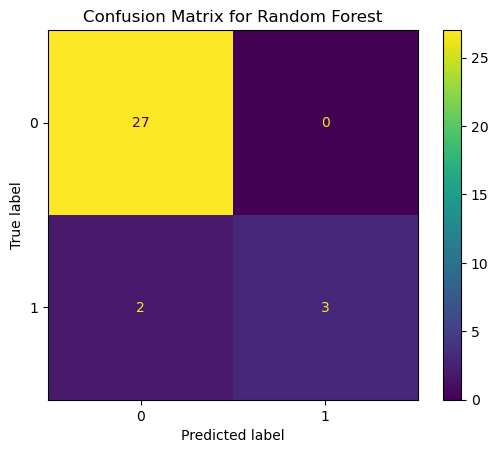

In [197]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.title(f'Confusion Matrix for Random Forest')
plt.show()

In [198]:
joblib.dump(SVMC,"SVMC_small.joblib")

['SVMC_small.joblib']

In [199]:
probabilities = SVMC.predict_proba(X)

# Get the probabilities of death class (assuming it's the second column, index 1)
death_probabilities = probabilities[:, 1]

# Combine with the test set for a complete view
X_with_prob = pd.DataFrame(X.copy())
X_with_prob['Death_Probability'] = death_probabilities

# Sort the dataframe by 'Death_Probability' in descending order to get the highest probabilities at the top
X_with_prob_sorted = X_with_prob.sort_values(by = 'Death_Probability', ascending=False)

# Display the top 10 instances with the highest death probability
print(X_with_prob_sorted.iloc[100])

gender                                                                     F
race                                                                   WHITE
lipase_level                                                           477.0
age                                                                       58
length_of_stay                                                      4.149306
                                                                      ...   
Ventricular tachycardia                                                False
Vitamin B12 deficiency anemia due to intrinsic factor deficiency       False
Wernicke's encephalopathy                                              False
Acute pancreatitis                                                      True
Death_Probability                                                   0.994315
Name: 106, Length: 181, dtype: object


In [57]:
def deadly_disease(n):
    true_columns = []
    for i in range(n):
        row_data = X_with_prob_sorted.iloc[i]
        true_columns = true_columns + row_data[row_data == True].index.tolist()
    return true_columns

In [201]:
# finding top occuring disease for 50 patients diagnosed with AP and has high chance of death 
from collections import Counter
Counter(deadly_disease(50))

Counter({'Acute pancreatitis': 50,
         'Unspecified septicemia': 18,
         'Acute kidney failure with lesion of tubular necrosis': 17,
         'Encounter for palliative care': 15,
         'Acute kidney failure with tubular necrosis': 15,
         'Do not resuscitate': 13,
         'Hyperpotassemia': 11,
         'Atrial fibrillation': 10,
         'Chronic kidney disease, unspecified': 10,
         'Severe sepsis with septic shock': 10,
         'Other and unspecified alcohol dependence, continuous': 8,
         'Nontraumatic compartment syndrome of abdomen': 8,
         'Congestive heart failure, unspecified': 7,
         'Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage I through stage IV, or unspecified': 7,
         'Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled': 6,
         'Coronary atherosclerosis of native coronary artery': 6,
         'Coagulation defect, unspecified': 5,